# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Профильное задание № 2 для направления биология.

**Правила:**

* Выполненную работу нужно отправить телеграм-боту, адрес которого будет указан на странице курса до конца недели. Обращаем ваше внимание, что в боте необходимо заранее зарегистрироваться и дождаться подтверждения.
* Дедлайн **15 мая в 23:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb` 
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.

-----

**Работа Закировой Марфы, Б06-907**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
!pip3 install pingouin
import pingouin as pg
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.linear_model import LinearRegression

from statsmodels.stats import multitest, multicomp
import statsmodels.formula.api as smf

import math
from scipy.special import logit

sns.set(font_scale=1.3)

Рак — весьма распространенное заболевание, поражающее многоклеточных животных. Причины развития онкологии могут быть весьма разнообразными, однако все они сводятся к соматическим мутациям в клетках. 

Кажется вполне очевидным тот факт, что увеличение числа клеток в организме должно привести к увеличению вероятности развития рака, если учесть, что каждое деление клетки несет в себе риск возникновения мутаций. Более того, организмы с большей продолжительностью жизни также должны быть больше подвержены раку (так как у клеток больше времени накопления мутаций). Действительно, среди людей и собак более крупные особи более склонны к развитию рака, чем более мелкие. Точно так же пожилой возраст является одним из наиболее влиятельных канцерогенных факторов у видов, у которых этиология рака хорошо изучена.

Однако, подобная зависимость не наблюдается в других таксонах. В 1977 году Ричард Пето сформалировал так называемый [парадокс Пето](https://ru.wikipedia.org/wiki/Парадокс_Пето), согласно которому заболеваемость раком не зависит от количества клеток в организме и продолжительности жизни. До недавнего времени это эмпирическое правило не было подтверждено комплексными исследованиями. В конце 2021 года в Nature была опубликована статья под названием [Cancer risk across mammals](https://www.nature.com/articles/s41586-021-04224-5), в которой ученые провели статистический анализ риска заболевания раком среди млекопитающих. Попробуем провести подобное исследование.

Загрузим данные с [github](https://github.com/OrsolyaVincze/VinczeEtal2021Nature). Скачайте файл `Data.csv`.

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Unnamed: 0,Species,order,FemaleMeanMass,MaleMeanMass,CMR,ICM,lifeexp,Sample,Deaths,Neoplasia,knownDeaths,Animal,Vertebrate,Invertebrate,Fish,Herptile,Bird,Mammal
0,1,Acinonyx_jubatus,Carnivora,39.906168,45.193976,0.035556,0.041555,3533.859621,1560,649,8,225,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2,Addax_nasomaculatus,Artiodactyla,102.281106,118.985007,0.035714,0.061624,3127.886214,762,336,3,84,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Aepyceros_melampus,Artiodactyla,42.373844,53.925686,0.057325,0.141182,2465.892908,1007,537,9,157,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Ailurus_fulgens,Carnivora,5.921639,6.029143,0.070707,0.073361,3580.261306,1068,421,7,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Alces_alces,Artiodactyla,292.792354,397.025427,0.000000,0.000000,2103.783182,246,147,0,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрите, какие есть столбцы в таблице.

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)  # удаляем лишний столбец
df.columns

Index(['Species', 'order', 'FemaleMeanMass', 'MaleMeanMass', 'CMR', 'ICM',
       'lifeexp', 'Sample', 'Deaths', 'Neoplasia', 'knownDeaths', 'Animal',
       'Vertebrate', 'Invertebrate', 'Fish', 'Herptile', 'Bird', 'Mammal'],
      dtype='object')

Для каждого вида приведена следующая информация:
* Species - научное название вида.
* order - отряд.
* FemaleMeanMass - средняя масса тела взрослых самок (кг).
* MaleMeanMass  - средняя масса тела взрослых самцов (кг).
* CMR - риск смертности от рака у взрослых особей (Cancer mortality risk). Переменная принимает значение от 0 до 1.
* ICM - частота смерти от рака у взрослых особей (Incidence of cancer mortality). Переменная принимает значение от 0 до 1.
* lifeexp - средняя продолжительность жизни после полового созревания, т.е. оставшаяся продолжительность жизни (в днях).
* Sample - общее число особей, принадлежащих к данному виду, в базе данных.
* Deaths - общее число смертей среди данного вида в базе данных.
* Neoplasia	- общее число случаев неоплазии, зарегистрированных у данного вида, которые можно считать существенной причиной смерти животного.
* knownDeaths - общее количество умерших особей, чьи патологоанатомические записи (т.е. наиболее вероятные причины смерти) были выявлены и внесены в базу данных животноводства.
* Animal - присутствие животных (1) или отсутствие (0) в рационе. 
* Vertebrate - наличие (1) или отсутствие (0) позвоночных в рационе.
* Invertebrate	- наличие (1) или отсутствие (0) непозвоночных в рационе.
* Fish - наличие (1) или отсутствие (0) рыбы в рационе.
* Herptile	- наличие (1) или отсутствие (0) рептилий в рационе.
* Bird - наличие (1) или отсутствие (0) птицы в рационе.
* Mammal - наличие (1) или отсутствие (0) млекопитающих в рационе.

Рассмотрим две метрики, представленные исследователями:
- Cancer mortality risk (CMR) - это отношение числа смертей, ассоциированных с раком, к общему числу смертей с доступными патологоанатомическими записями. Однако эта метрика не учитывает живых индивидов, страдающих от рака. Для учета этого факта была введена другая метрика:
- Incidence of cancer mortality (ICM) - метрика, призванная учесть "усечение распределения слева" (т.е. учет организмов с раком, но еще не попавших в выборку) и "усечение справа" (учет больных раком особей, смерть которых еще не наступила). Для вычисления ICM используется оценщик Каплана-Мейера (Kaplan–Meier estimator), который представляет собой непараметрическую статистику, используемую для оценки функции выживаемости на основе данных о продолжительности жизни.

Для дальнейшего анализа добавим столбец `bodyMass` со средней массой особи каждого вида как среднее масс самок и самцов. Переведем продолжительность жизни в года.

In [5]:
df['bodyMass'] = (df['FemaleMeanMass'] + df['MaleMeanMass'])/2
df.lifeexp /= 365

### Задача 1. Зависимость риска рака от принадлежности к отряду

В исследовании использовались две метрики для оценки смертности от рака: `CRM` и `ICM`. По смыслу они кажутся очень похожими. Постройте график, по осям которого отложены значения CRM и ICM для каждого вида. Для этого удобно воспользоваться функцией библиотеки seaborn `jointplot`. Уберите строки, в которых есть NaN хотя бы в одном из этих двух столбцов. Посчитайте коэффициент(-ы) корреляции (Пирсона/Спирмена/Кендалла). Поясните, почему вы выбрали тот или иной коэффициент(-ы). Сделайте вывод.

*Совет: воспользуйтесь логарифмическими координатами.*

In [6]:
index_to_drop = df.index[df[['CMR','ICM']].isna().sum(axis = 1) != 0]
df = df.drop(index_to_drop)

df2 = df.copy()
df2['log(CMR)'], df2['log(ICM)'] = np.log(df['CMR']), np.log(df['ICM'])

spearman = sps.spearmanr(df['CMR'], df['ICM']) 
kendall = sps.kendalltau(df['CMR'], df['ICM'])
pd.DataFrame({'Коэфф. корреляции': np.round([spearman[0], kendall[0]],3), 'p-value': multipletests([spearman[1],kendall[1]], method = 'holm')[1]}, index = ['Спирмен', 'Кендалл']) 
 

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Коэфф. корреляции,p-value
Спирмен,0.929,7.829067e-75
Кендалл,0.792,3.423093e-49


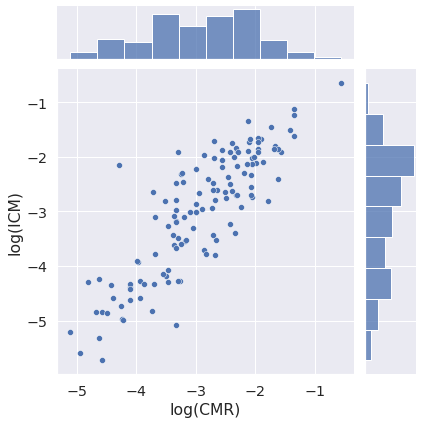

In [7]:
sns.jointplot(x= 'log(CMR)', y='log(ICM)', data=df2, kind="scatter")

**Вывод:** 

**Посчитаем коэффициенты корреляции Спирмена и Кендалла, не Пирсона, так как последний предполагает наличие линейной зависимости между данными из нормального распределения, что может не выполняться.** 

**Заметим что если**

$y = f(x)$


$log(y) = log(f(x))  = F(x)$

**то есть при логарифмировании зависимость сохраняется, а в силу монотонности логарифма не меняется тип зависимости.**

**Для обоих проверок корреляции получилось большое значение коэффициента, что говорит о том, что значения CMR и ICM лежат на монотонной кривой, гипотеза о независимости отвергается. Этот факт подтверждается графически.**

Посмотрите, какие отряды представлены в данных и сколько видов животных в них. Создайте список отрядов, представленных двумя видами и больше.

In [8]:
print(f'Отряды: {df.order.unique()}')
print(f'Число видов: {df.Species.unique().shape[0]}')

orders2 = []
for order in df['order'].unique():
  if df[df['order'] == order]['Species'].unique().shape[0] >=2:
    orders2.append(order)
print(f'Отряды, представленные 2 видами и больше: {orders2}')

Отряды: ['Carnivora' 'Artiodactyla' 'Primates' 'Diprotodontia' 'Rodentia'
 'Chiroptera' 'Dasyuromorphia' 'Afrosoricida' 'Perissodactyla'
 'Macroscelidea' 'Hyracoidea' 'Scandentia']
Число видов: 172
Отряды, представленные 2 видами и больше: ['Carnivora', 'Artiodactyla', 'Primates', 'Diprotodontia', 'Rodentia', 'Chiroptera', 'Perissodactyla']


Визуализируйте данные, построив `violinplot` с распределением CMR (дальше будем рассматривать только эту метрику) для каждого отряда. Постройте все на одной `matplotlib`-фигуре, а также визуализируйте на violinplot точки из выборок. Подпишите отряды и число видов, представляющих их. Какие можно сделать предварительные выводы?

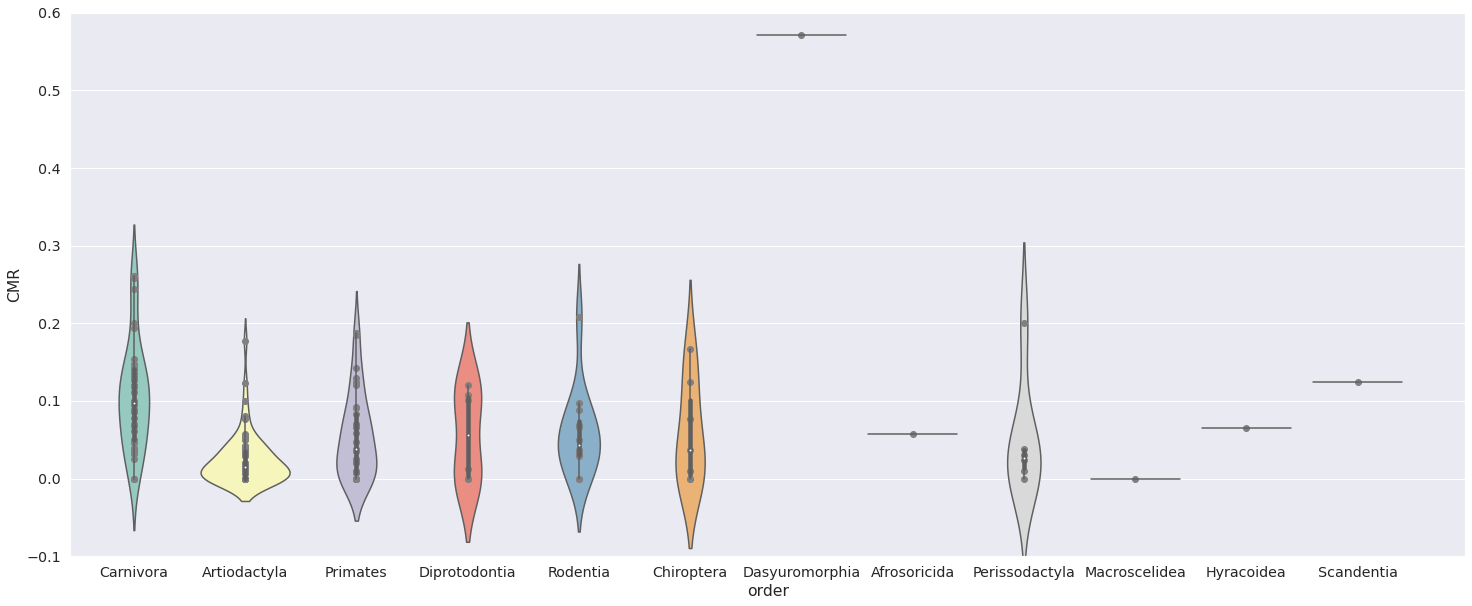

In [9]:
plt.figure(figsize=(25,10))
sns.violinplot(y="CMR", x ='order', data=df, palette="Set3")
plt.scatter(y="CMR", x ='order', data=df, color = 'grey')
plt.ylim((-0.1, 0.6))
plt.show()

**Вывод:** 


**Есть набор отрядов, данных по которым так мало, что и плот нормально не построится $⇒$ о распределении ничего предположить не можем, например Dasyuromotphia представлена одной точкой. В целом распределния между отрядами различаются, но среднее значение CMR в большинстве своем зажато в интервале (0,0.1), квантили в (0, 0.2).**

Теперь посмотрим на статистическую значимость этих различий между отрядами. 

Проведите однофакторный дисперсионный анализ (oneway ANOVA) с помощью критерия Фишера `scipy.stats.f_oneway` или критерия Краскела-Уоллиса `scipy.stats.kruskal`. Какой из критериев применим для наших данных? Проверьте гипотезу о равенстве дисперсий данных с помощью критерия Бартлетта `scipy.stats.bartlett` или критерия Левена `scipy.stats.levene` (про критерий Левена можно прочитать [здесь](https://en.wikipedia.org/wiki/Levene%27s_test)). Какой можно сделать вывод?

In [ ]:
#help(sps.f_oneway)

In [ ]:
# help(sps.kruskal)

In [ ]:
# help(sps.bartlett)

In [ ]:
# help(sps.levene)

In [10]:
orders = df['order'].unique()
cmr_data = [[] for _ in range(orders.shape[0])]

for i, order in enumerate(orders):
  cmr_data[i] = df[df['order'] == order]['CMR']

p_vals = multipletests([sps.kruskal(*cmr_data)[1], sps.levene(*cmr_data)[1]], method = 'holm')[1]
print(f'Краскела-Уоллиса: {np.round(p_vals[0],3)}')
print(f'Левена: {np.round(p_vals[1],3)}')

Краскела-Уоллиса: 0.0
Левена: 0.009


**Проверим для отрядов представленных в более чем двух видах:**

In [18]:
cmr_data2 = [[] for _ in range(len(orders2))]

for i, order in enumerate(orders2):
  cmr_data2[i] = df[df['order'] == order]['CMR']
  p_vals2 = multipletests([sps.kruskal(*cmr_data)[1], sps.levene(*cmr_data)[1]], method = 'holm')[1]
print(f'Краскела-Уоллиса: {np.round(p_vals2[0],3)}')
print(f'Левена: {np.round(p_vals2[1],3)}')

Краскела-Уоллиса: 0.0
Левена: 0.009


**Вывод:** 

**Критерий Фишера параметрический для нормальных выборок, по KDE видно что не все распределения похожи на нормальное. Воспользуемся критерием Краскера - Уоллиса, непараметрическим. Гипотеза о равенстве средних значений CMR среди всех видов отвергается, что в приницпе было понятно и по ящикам с усами.**

**Для проверки равенства дисперсий воспользуемся критерием Левена, так как считается, что он менее чувствителен к отклонениям от нормальности. Аналогично получаем отвержение гипотезы о равенстве дисперсий.**

Теперь можно провести post hoc анализ. Необходимо вычислить, между какими выборками существуют значимые различия.
Для этого создайте список всех возможных пар отрядов, в которых количество видов не меньше двух. Посчитайте с помощью t-критерия (буква t означает, что в критерии используется распределение Стьюдента) p-value для всех возможных пар. Занесите результаты в таблицу, указав помимо p-value разницу средних между отрядами и результат проверки гипотезы о равенстве средних. Не забудьте про МПГ. Какой метод лучше использовать в данном случае?

*Подсказка: какой из t-критериев здесь стоит использовать? См.  лекцию 11.*

**Ничего о равенстве дисперсий для каждой пары выборок не знаем $⇒$ для проверки равенства средних воспользуемся t-критерием Аспина - Уэлша. Проверку FWER делаем с помошью метода Холма, так как проверяемые случаи зависимы для смежных пар.**

In [47]:
import itertools
pairs =[list(pair) for pair in itertools.combinations(orders2, 2)]

table = pd.DataFrame({'pairs': 0, 'p-vals': 0, '(mean1-mean2)': 0, 'statistics': 0}, index =[0])
for pair in pairs:
  sample1, sample2  = df[df['order'] == pair[0]]['CMR'], df[df['order'] == pair[1]]['CMR']
  test = sps.ttest_ind(sample1, sample2, equal_var=False)
  newline = {}
  newline = {'pairs': pair, 'p-vals': test[1], '(mean1-mean2)': np.mean(sample1) - np.mean(sample2), 'statistics': test[0]}
  table = table.append(newline, ignore_index=True)

table=table.drop([0])
table['p-vals'] =  multipletests(table['p-vals'].to_numpy(), method = 'holm')[1]
table

,pairs,p-vals,(mean1-mean2),statistics
1,"[Carnivora, Artiodactyla]",8.817852e-08,0.082181,7.048430
2,"[Carnivora, Primates]",1.358058e-02,0.051258,3.552062
3,"[Carnivora, Diprotodontia]",1.000000e+00,0.049796,1.905961
4,"[Carnivora, Rodentia]",4.424489e-01,0.047034,2.413312
5,"[Carnivora, Chiroptera]",1.000000e+00,0.047013,1.728697
6,"[Carnivora, Perissodactyla]",1.000000e+00,0.056052,1.732919
7,"[Artiodactyla, Primates]",8.628011e-02,-0.030923,-2.988512
8,"[Artiodactyla, Diprotodontia]",1.000000e+00,-0.032385,-1.343062
9,"[Artiodactyla, Rodentia]",9.533955e-01,-0.035147,-2.105502
10,"[Artiodactyla, Chiroptera]",1.000000e+00,-0.035169,-1.391886


Теперь попробуем воспользоваться критерием `HSD Тьюки`, который используется в большинстве случаев, потому что он контролирует ошибки первого рода. Однако в основе критерия также лежит предположение о нормальности и гомоскедастичности выборок (равная дисперсия), поэтому в нашем случае лучше воспользоваться критерием `Геймса-Хауэлла` из библиотки pingouin ([подробнее](https://rpubs.com/aaronsc32/games-howell-test)). Получите и сравните результаты теста Тьюки и Хауэлла. Сделайте вывод.

In [ ]:
help(multicomp.pairwise_tukeyhsd)

In [ ]:
help(pg.pairwise_gameshowell)

In [34]:
tukey = multicomp.pairwise_tukeyhsd(endog = df[df['order'].isin(orders2)].CMR,
                                    groups = df[df['order'].isin(orders2)].order, alpha = 0.05)
print(tukey)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
  Artiodactyla      Carnivora   0.0822    0.0  0.0499  0.1144   True
  Artiodactyla     Chiroptera   0.0352 0.6537 -0.0287   0.099  False
  Artiodactyla  Diprotodontia   0.0324 0.7945 -0.0361  0.1009  False
  Artiodactyla Perissodactyla   0.0261 0.9148 -0.0423  0.0946  False
  Artiodactyla       Primates   0.0309 0.1112 -0.0036  0.0654  False
  Artiodactyla       Rodentia   0.0351 0.3708 -0.0154  0.0857  False
     Carnivora     Chiroptera   -0.047 0.3326 -0.1125  0.0185  False
     Carnivora  Diprotodontia  -0.0498 0.3436 -0.1198  0.0202  False
     Carnivora Perissodactyla  -0.0561 0.2092 -0.1261   0.014  False
     Carnivora       Primates  -0.0513 0.0013 -0.0887 -0.0138   True
     Carnivora       Rodentia   -0.047 0.1123 -0.0996  0.0055  False
    Chiroptera  Diprotodontia  -0.

In [41]:
ping = pg.pairwise_gameshowell(data=df[df['order'].isin(orders2)], between="order", dv="CMR")
print(ping)

                 A               B   mean(A)   mean(B)      diff        se  \
0     Artiodactyla       Carnivora  0.024251  0.106432 -0.082181  0.011660   
1     Artiodactyla      Chiroptera  0.024251  0.059419 -0.035169  0.025267   
2     Artiodactyla   Diprotodontia  0.024251  0.056636 -0.032385  0.024113   
3     Artiodactyla  Perissodactyla  0.024251  0.050380 -0.026130  0.030741   
4     Artiodactyla        Primates  0.024251  0.055174 -0.030923  0.010347   
5     Artiodactyla        Rodentia  0.024251  0.059398 -0.035147  0.016693   
6        Carnivora      Chiroptera  0.106432  0.059419  0.047013  0.027195   
7        Carnivora   Diprotodontia  0.106432  0.056636  0.049796  0.026127   
8        Carnivora  Perissodactyla  0.106432  0.050380  0.056052  0.032345   
9        Carnivora        Primates  0.106432  0.055174  0.051258  0.014431   
10       Carnivora        Rodentia  0.106432  0.059398  0.047034  0.019489   
11      Chiroptera   Diprotodontia  0.059419  0.056636  0.002784

**Вывод:** 

**Для пар (Artiodactyla, Carnivora), (Carnivora, Primates) для уровня $\alpha = 0.05$ гипотеза о равенстве средних отвергается обоими критериями, в большей степени полагаемся на критерий Геймса-Хауэлла**

### Задача 2. Зависимость риска рака от половой принадлежности

Авторы статьи выдвинули несколько предположений о причине столько высокого риска рака у отряда хищников (Carnivora). Одна из них заключается в том, что в зоопарках часто используют гормональные контрацептивы для животных (напр., прогестины) и часто наблюдается отложенная беременность. Эти факторы могут быть факторами риска у человека и кошачих. Однако, если принять в расчет эту гипотезу, становится очевидно, что у самок должен быть повышен риск рака, так как перечисленные факторы касаются именно их. 

Загрузите таблицу [Sex-specific-ICM_CMR.csv](https://github.com/OrsolyaVincze/VinczeEtal2021Nature/blob/main/Sex-specific_ICM_CMR.csv). Здесь представлены значения CMR и ICM отдельно для самок и самцов отряда хищных. Проверьте, есть ли зависимость риска рака от половой принадлежности с помощью t-критерия. Какой именно нужно использовать? Сделайте вывод.

In [50]:
sex_data = pd.read_csv('Sex-specific_ICM_CMR.csv')

In [51]:
sex_data.head()

,Species,knownDeathsF,knownDeathsM,ICM_F,ICM_M,CMR_M,CMR_F,order
0,Acinonyx_jubatus,105,120,0.030140,0.048123,0.033333,0.038095,Carnivora
1,Ailurus_fulgens,47,51,0.115641,0.044528,0.058824,0.085106,Carnivora
2,Aonyx_cinerea,85,74,0.146708,0.015496,0.040541,0.082353,Carnivora
3,Arctictis_binturong,14,13,0.064764,0.188874,0.153846,0.142857,Carnivora
4,Canis_rufus,17,14,0.188612,0.413090,0.428571,0.117647,Carnivora


In [52]:
sex_data.columns

Index(['Species', 'knownDeathsF', 'knownDeathsM', 'ICM_F', 'ICM_M', 'CMR_M',
       'CMR_F', 'order'],
      dtype='object')

In [53]:
female = sex_data[['Species', 'knownDeathsF', 'ICM_F','CMR_F', 'order']]
female.columns = ['Species', 'knownDeaths', 'ICM','CMR', 'order']
female['sex'] = ['female' for _ in range(female.shape[0])]

male = sex_data[['Species', 'knownDeathsM', 'ICM_M','CMR_M', 'order']]
male.columns = ['Species', 'knownDeaths', 'ICM','CMR', 'order']
male['sex'] = ['male' for _ in range(male.shape[0])]
sex_plot = pd.concat([female,male])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


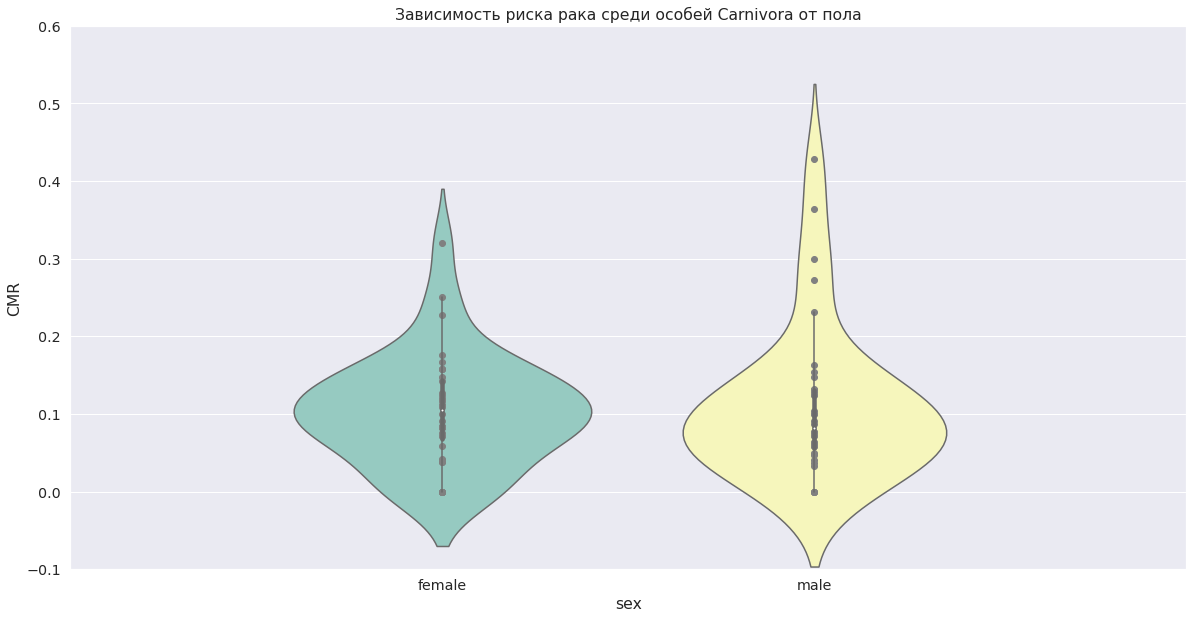

In [54]:
plt.figure(figsize=(20,10))
sns.violinplot(y="CMR", x ='sex', data=sex_plot, palette="Set3")
plt.scatter(y="CMR", x ='sex', data=sex_plot, color = 'grey')
plt.ylim((-0.1, 0.6))
plt.xlim(-1,2)
plt.title('Зависимость риска рака среди особей Carnivora от пола')
plt.show()

**Риск рака == CMR**

**По KDE видно что дисперсии близки, проверим зависимость риска рака от половой принадлежности с помощью критерия Стьюдента**

In [55]:
sps.ttest_ind(female['CMR'], male['CMR'], equal_var=True)

Ttest_indResult(statistic=-0.3131762718650713, pvalue=0.7550779736094833)

**Вывод:**


**Таким образом, гипотеза о равенстве средних не отвергается, то есть скорее всего завимости рака от пола нет.**

